In [1]:
from mobility.get_insee_data import get_insee_data
from mobility.parsers import download_work_home_flows
import mobility.radiation_model as rm
import numpy as np
import pandas as pd
import os
import time
from pathlib import Path
from mobility.parsers import communes
COMMUNES_COORDINATES_CSV = "donneesCommunesFrance.csv"
COMMUNES_SURFACES_CSV = "donneesCommunesFrance.csv"
WORK_HOME_FLUXES_CSV = download_work_home_flows()

In [3]:
# Calculate Internal Distances
from scipy.spatial.distance import cdist
def internal_distances(data):
    # Drop Nan value 
    df1=data.dropna(subset=['INSEE_COM','x', 'y'])
    distances = cdist(df1[['x', 'y']], df1[['x', 'y']], 'euclidean')
    distance_interne = []
    for i in range(len(distances)):
        distance_interne.append({'INSEE_COM': df1.iloc[i]['INSEE_COM'], 'distance_interne': (distances[i].sum())/len(distances)})

    # Convert the results to a DataFrame
    distance_interne = pd.DataFrame(distance_interne)
    return distance_interne

In [4]:
def compare_thresholds(
    predicted_flux, empirical_flux, thresholds=[400, 200, 100, 50, 25, 20, 15, 10, 5]
):
    for t in thresholds:
        compute_similarity_index(predicted_flux, empirical_flux, t)


def compute_similarity_index(predicted_flux, empirical_flux, threshold=200):
    ssi = 0
    n = 0
    under_threshold = 0
    exc = 0
    for pair in empirical_flux.iterrows():
        pair_ids = pair[0]
        t2_ij = float(pair[1])
        if t2_ij >= threshold:
            try:
                t_ij = float(predicted_flux.loc[pair_ids])
                if t_ij + t2_ij > 0:
                    ssi += 2 * min(t_ij, t2_ij) / (t_ij + t2_ij)
                    n += 1
            except KeyError:
                exc += 1
                n += 1
                pass
        else:
            under_threshold += 1
    ssi = ssi / n
    ssi_print = f"{ssi:.3f}"
    print(
        "Similarity index:",
        ssi_print,
        "after",
        n,
        "steps.",
        under_threshold,
        "pairs under a threshold of",
        threshold,
        "--",
        exc,
        "exceptions",
    )
    return ssi



In [5]:
def run_model_for_territory(
    sources_territory,
    sinks_territory,
    costs_territory,
    coordonnees,
    raw_flowDT,
    alpha=0,
    beta=1,
):
    print(
        "Model running with {} sources, {} sinks and {} costs".format(
            len(sources_territory), len(sinks_territory), len(costs_territory)
        )
    )
    print("still")

    # COMPUTE THE MODEL
    (total_flows, source_rest_volume, sink_rest_volume) = rm.iter_radiation_model(
        sources_territory,
        sinks_territory,
        costs_territory,
        alpha=alpha,
        beta=beta,
        plot=False,
    )
    print("ok")
    # PLOT THE SOURCES AND THE SINKS

    plot_sources = sources_territory.rename(columns={"source_volume": "volume"})
    rm.plot_volume(plot_sources, coordonnees, n_locations=10, title="Volume d'actifs")

    plot_sinks = sinks_territory.rename(columns={"sink_volume": "volume"})
    rm.plot_volume(plot_sinks, coordonnees, n_locations=10, title="Volume d'emplois")

    # PLOT THE FLOWS COMPUTED BY THE MODEL
    print("yes")
    plot_flows = total_flows.reset_index()
    plot_sources = sources_territory

    rm.plot_flow(
        plot_flows,
        coordonnees,
        sources=None,
        n_flows=500,
        n_locations=20,
        size=10,
        title=(
            "(1) Flux domicile-travail générés par le modèle"
            " - alpha = {} - beta = {}"
        ).format(alpha, beta),
    )

    # PLOT THE FLOWS FROM THE INSEE DATA
    print("no")
    plot_flowDT = raw_flowDT.groupby(["COMMUNE", "DCLT"])["IPONDI"].sum().reset_index()
    plot_flowDT.rename(
        columns={"IPONDI": "flow_volume", "COMMUNE": "from", "DCLT": "to"}, inplace=True
    )

    rm.plot_flow(
        plot_flowDT,
        coordonnees,
        sources=plot_sources,
        n_flows=500,
        n_locations=20,
        size=10,
        title="(2) Flux domicile-travail mesurés par l'INSEE",
    )

    # EXPORT THE MODEL AND THE INSEE DATA

    flowDT = raw_flowDT.rename(
        columns={"IPONDI": "flow_volume", "COMMUNE": "from", "DCLT": "to"}
    )
    flowDT = flowDT.groupby(["from", "to"])["flow_volume"].sum()
    flowDT = pd.DataFrame(flowDT)

    flowsRM = pd.DataFrame(total_flows)

    print("Model flow of {} and empirical flow of {}".format(len(flowsRM), len(flowDT)))

    return flowsRM, flowDT, coordonnees, plot_sources

In [6]:
def optimise_parameters(
    sources_territory,
    sinks_territory,
    costs_territory,
    coordonnees,
    raw_flowDT,
    coef=1,
    threshold=20,
):
    best_score = 0
    print("Finding the best α,β pair")
    for alpha in np.arange(0, 1.1, 0.1):
        for beta in np.arange(0, 1.1, 0.1):
            if alpha + beta < 1.05:
                print(f"\n\nα = {alpha:.1f}, β ={beta:.1f}")
                (
                    predicted_flux,
                    empirical_flux,
                    coordonnees,
                    plot_sources,
                ) = run_model_for_territory(
                    sources_territory.copy(),
                    sinks_territory,
                    costs_territory,
                    coordonnees,
                    raw_flowDT,
                    alpha=alpha,
                    beta=beta,
                )

                ssi = compute_similarity_index(
                    coef * predicted_flux, empirical_flux, threshold
                )
                if ssi > best_score:
                    best_score = ssi
                    best_pair = [alpha, beta]
    print("Best α,β pair found is", best_pair)
    return best_pair

In [13]:
def compare_insee_and_model(predicted_flux, empirical_flux, coordonnees, plot_sources):
    
    # Join on the couple origin destinations
    # how = 'inner' to keep only the couples that are in both dataframes
    flow_join = empirical_flux.join(
        predicted_flux, how="inner", lsuffix="DT", rsuffix="RM"
    )
    flow_join.reset_index(inplace=True)

    # Compare visually model and INSEE data
    fig = flow_join.plot(x="flow_volumeDT", y="flow_volumeRM", style="o")
    # fig.set_xlim(0,2500) # Use this to set the limit of the figure if needed
    # fig.set_ylim(0,2500)

    # Compare the total flow
    print("The 2 dataframes have {} OD in common\n".format(flow_join.shape[0]))

    sum_flow_DT = flow_join["flow_volumeDT"].sum()
    intra_flow_mask = flow_join["from"] == flow_join["to"]
    intra_flow_DT = flow_join.loc[intra_flow_mask, "flow_volumeDT"].sum()
    print(
        "Total flow of the INSEE data :\n"
        "   {:.0f} ({:.0f}% intra-city flow)".format(
            sum_flow_DT, 100 * intra_flow_DT / sum_flow_DT
        )
    )

    sum_flow_RM = flow_join["flow_volumeRM"].sum()
    intra_flow_RM = flow_join.loc[intra_flow_mask, "flow_volumeRM"].sum()
    intra_city_flow = 100 * intra_flow_RM / sum_flow_RM
    print(
        "Total flow of the model :\n"
        "   {:.0f} ({:.0f}% intra-city flow)\n".format(sum_flow_RM, intra_city_flow)
    )

    # Compare the repartition between the ODs
    flow_join["repartitionDT"] = (
        flow_join["flow_volumeDT"] / flow_join["flow_volumeDT"].sum()
    )
    flow_join["repartitionRM"] = (
        flow_join["flow_volumeRM"] / flow_join["flow_volumeRM"].sum()
    )

    error_repartition = np.abs(flow_join["repartitionDT"] - flow_join["repartitionRM"])

    print(
        "The repartitions from the INSEE data and the data"
        "have {:.2f}% in common.".format(100 - 50 * error_repartition.sum())
    )

    # similarity = compute_similarity_index(flowRM,flowDT)
    # print("Similarity between the model and the INSEE data is ", similarity)

    plot_DT = pd.DataFrame(flow_join[["from", "to", "repartitionDT"]])
    plot_DT.rename(columns={"repartitionDT": "flow_volume"}, inplace=True)
    plot_RM = pd.DataFrame(flow_join[["from", "to", "repartitionRM"]])
    plot_RM.rename(columns={"repartitionRM": "flow_volume"}, inplace=True)

    rm.plot_flow(
        plot_DT,
        coordonnees,
        sources=plot_sources,
        n_flows=500,
        size=10,
        n_locations=20,
        title="(3) Flux domicile-travail mesurés par l'INSEE",
    )
    
    rm.plot_flow(
        plot_RM,
        coordonnees,
        sources=plot_sources,
        n_flows=500,
        size=10,
        n_locations=20,
        title="(4) Flux domicile-travail générés par le modèle",
    )
    return error_repartition


def get_data_for_model(
    lst_departments,
    communes_coordinates_csv=COMMUNES_COORDINATES_CSV,
    communes_surfaces_csv=COMMUNES_SURFACES_CSV,
    alpha=0,
    beta=1,
):
    """
    Gets data for the given departments.

    Uses the get_insee_data function for active population ans jobs
    Uses local data for communes' superficies, intra-communal distance
    and work-home mobility
    (by default, will use the national CSVs in the directory)
    Todo:
     * improve the get_insee_data function for work-home data, coordinates
       and superficies, to not have to deal with local data
     * compute the internal distance within the code instead of using a CSV

    Parameters
    ----------
    lst_departments : list
        List of departements for which to get the data.
    work_home_fluxes_csv : string, optional
        Which CSV to use for work-home data.
        The default is WORK_HOME_FLUXES_CSV defined at the top of the file.
    communes_coordinates_csv : string, optional
        Which CSV to use for coordinates data.
        The default is COMMUNES_COORDINATES_CSV.
    communes_surfaces_csv : string, optional
        Which CSV to use for surfaces data.
        The default is COMMUNES_SURFACES_CSV.
    alpha : float, optional
        The default is 0.
    beta : float, optional
        The default is 1.

    Returns sources_territory, sinks_territory, costs_territory,
            coordonnees, raw_flowDT
            (all of them are pandas dataframes)

    """
    # ===================
    # IMPORT AND PROCESS THE DATA

    # Import the data (active population and jobs)
    insee_data = get_insee_data()
    db_actifs = insee_data["active_population"]
    db_sport = insee_data["sport"]
    raw_flowDT=insee_data["raw_flowDT"]
    
    #coordonnees=insee_data["coordonnees"]
    #surf=insee_data["coordonnees"]
    db_sport = db_sport.rename_axis('CODGEO')

    '''
    db_emplois["EMPLT"] = db_emplois[
        [
            "n_jobs_CS1",
            "n_jobs_CS2",
            "n_jobs_CS3",
            "n_jobs_CS4",
            "n_jobs_CS5",
            "n_jobs_CS6",
        ]
    ].sum(axis=1)
    db_emplois.reset_index(inplace=True)'''
    
    db_actifs["ACT"] = db_actifs[
        [
            "active_pop_CS1",
            "active_pop_CS2",
            "active_pop_CS3",
            "active_pop_CS4",
            "active_pop_CS5",
            "active_pop_CS6",
        ]
    ].sum(axis=1)
    db_actifs.reset_index(inplace=True)
    '''
    # Only keep the sinks in the chosen departements
    sinks_territory = db_emplois.loc[:, ["CODGEO", "EMPLT"]]
    sinks_territory["DEP"] = sinks_territory["CODGEO"].str.slice(0, 2)
    mask = sinks_territory["DEP"].apply(lambda x: x in lst_departments)
    sinks_territory = sinks_territory.loc[mask]
    
    sinks_territory = sinks_territory.set_index("CODGEO")
    sinks_territory.rename(columns={"EMPLT": "sink_volume"}, inplace=True)
    sinks_territory = sinks_territory.drop(columns=["DEP"])
    '''
    # Only keep the sinks in the chosen departements
    sources_territory = db_actifs.loc[:, ["CODGEO", "ACT"]]
    sources_territory["DEP"] = sources_territory["CODGEO"].str.slice(0, 2)
    mask = sources_territory["DEP"].apply(lambda x: x in lst_departments)
    sources_territory = sources_territory.loc[mask]

    sources_territory = sources_territory.set_index("CODGEO")
    sources_territory = sources_territory.drop(columns=["DEP"])
    sources_territory.rename(columns={"ACT": "source_volume"}, inplace=True)

    data_folder_path = Path(os.path.dirname("examples/Millau/"))

    # Import the INSEE data on the work-home mobility on Millau
    # Only keep the flows in the given departments

    raw_flowDT["DEP"] = raw_flowDT["COMMUNE"].str.slice(0, 2)
    raw_flowDT["DEP2"] = raw_flowDT["DCLT"].str.slice(0, 2)
    mask = raw_flowDT["DEP"].apply(lambda x: x in lst_departments)
    mask2 = raw_flowDT["DEP2"].apply(lambda x: x in lst_departments)
    raw_flowDT = raw_flowDT.loc[mask]
    raw_flowDT = raw_flowDT.loc[mask2]

    # Import the geographic data on the work-home mobility on Millau
    
    # Import the geographic data on the work-home mobility on Millau

    coordonnees = pd.read_csv(
        data_folder_path / communes_coordinates_csv,
        sep=",",
        usecols=["NOM_COM", "INSEE_COM", "x", "y"],
        dtype={"INSEE_COM": str},
    )
    coordonnees.set_index("INSEE_COM", inplace=True)
    coordonnees["x"] = coordonnees["x"] * 1000
    coordonnees["y"] = coordonnees["y"] * 1000

    surfaces = pd.read_csv(
        data_folder_path / communes_surfaces_csv,
        sep=",",
        usecols=["INSEE_COM", "distance_interne"],
        dtype={"INSEE_COM": str},
    )
    surfaces.set_index("INSEE_COM", inplace=True)

    # Compute the distance between cities
    #    distance between i and j = (x_i - x_j)**2 + (y_i - y_j)**2
    lst_communes = sources_territory.index.to_numpy()
    idx_from_to = np.array(np.meshgrid(lst_communes, lst_communes)).T.reshape(-1, 2)
    idx_from = idx_from_to[:, 0]
    idx_to = idx_from_to[:, 1]
    costs_territory = pd.DataFrame(
        {"from": idx_from, "to": idx_to, "cost": np.zeros(idx_to.shape[0])}
    )
    costs_territory = pd.merge(
        costs_territory, coordonnees, left_on="from", right_index=True
    )
    costs_territory.rename(columns={"x": "from_x", "y": "from_y"}, inplace=True)
    costs_territory = pd.merge(
        costs_territory, coordonnees, left_on="to", right_index=True
    )
    costs_territory.rename(columns={"x": "to_x", "y": "to_y"}, inplace=True)

    costs_territory = pd.merge(
        costs_territory, surfaces, left_on="from", right_index=True
    )

    costs_territory["cost"] = np.sqrt(
        (costs_territory["from_x"] / 1000 - costs_territory["to_x"] / 1000) ** 2
        + (costs_territory["from_y"] / 1000 - costs_territory["to_y"] / 1000) ** 2
    )

    # distance if the origin and the destination is the same city
    # is internal distance = 128*r / 45*pi
    # where r = sqrt(surface of the city)/pi
    mask = costs_territory["from"] != costs_territory["to"]
    costs_territory["cost"].where(
        mask, other=costs_territory["distance_interne"], inplace=True
    )

    return (
        sources_territory,
        sinks_territory,
        costs_territory,
        coordonnees,
        raw_flowDT,
    )

Writing the INSEE (parquet/csv) files.
Model running with 1444 sources, 1444 sinks and 2085136 costs
still
Iteration n°1 of the radiation model
Iteration n°2 of the radiation model
ok
yes


c:\Users\HP\Desktop\projet TT\mobility-main\mobility-main\mobility\radiation_model.py:498: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  internal_flows.loc[:, "flow_volume"] = (
c:\Users\HP\Desktop\projet TT\mobility-main\mobility-main\mobility\radiation_model.py:515: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  internal_flows.sort_values(by="flow_volume", ascending=False, inplace=True)


no
Model flow of 2085136 and empirical flow of 23867
The 2 dataframes have 23867 OD in common

Total flow of the INSEE data :
   925366 (45% intra-city flow)
Total flow of the model :
   872035 (43% intra-city flow)

The repartitions from the INSEE data and the datahave 70.10% in common.
Similarity index: 0.799 after 275 steps. 23592 pairs under a threshold of 400 -- 0 exceptions
Similarity index: 0.743 after 614 steps. 23253 pairs under a threshold of 200 -- 0 exceptions
Similarity index: 0.680 after 1260 steps. 22607 pairs under a threshold of 100 -- 0 exceptions
Similarity index: 0.617 after 2425 steps. 21442 pairs under a threshold of 50 -- 0 exceptions
Similarity index: 0.543 after 4453 steps. 19414 pairs under a threshold of 25 -- 0 exceptions
Similarity index: 0.518 after 5368 steps. 18499 pairs under a threshold of 20 -- 0 exceptions
Similarity index: 0.483 after 6891 steps. 16976 pairs under a threshold of 15 -- 0 exceptions
Similarity index: 0.430 after 9825 steps. 14042 pair

0.518182703214588

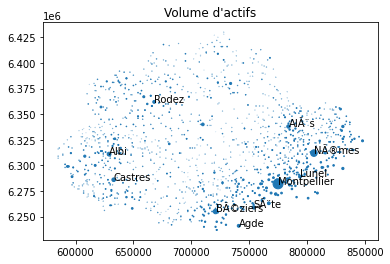

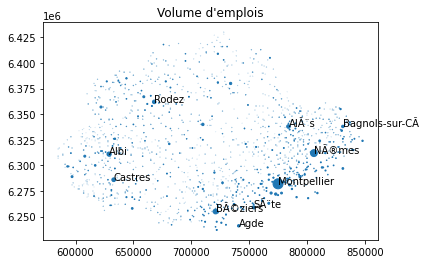

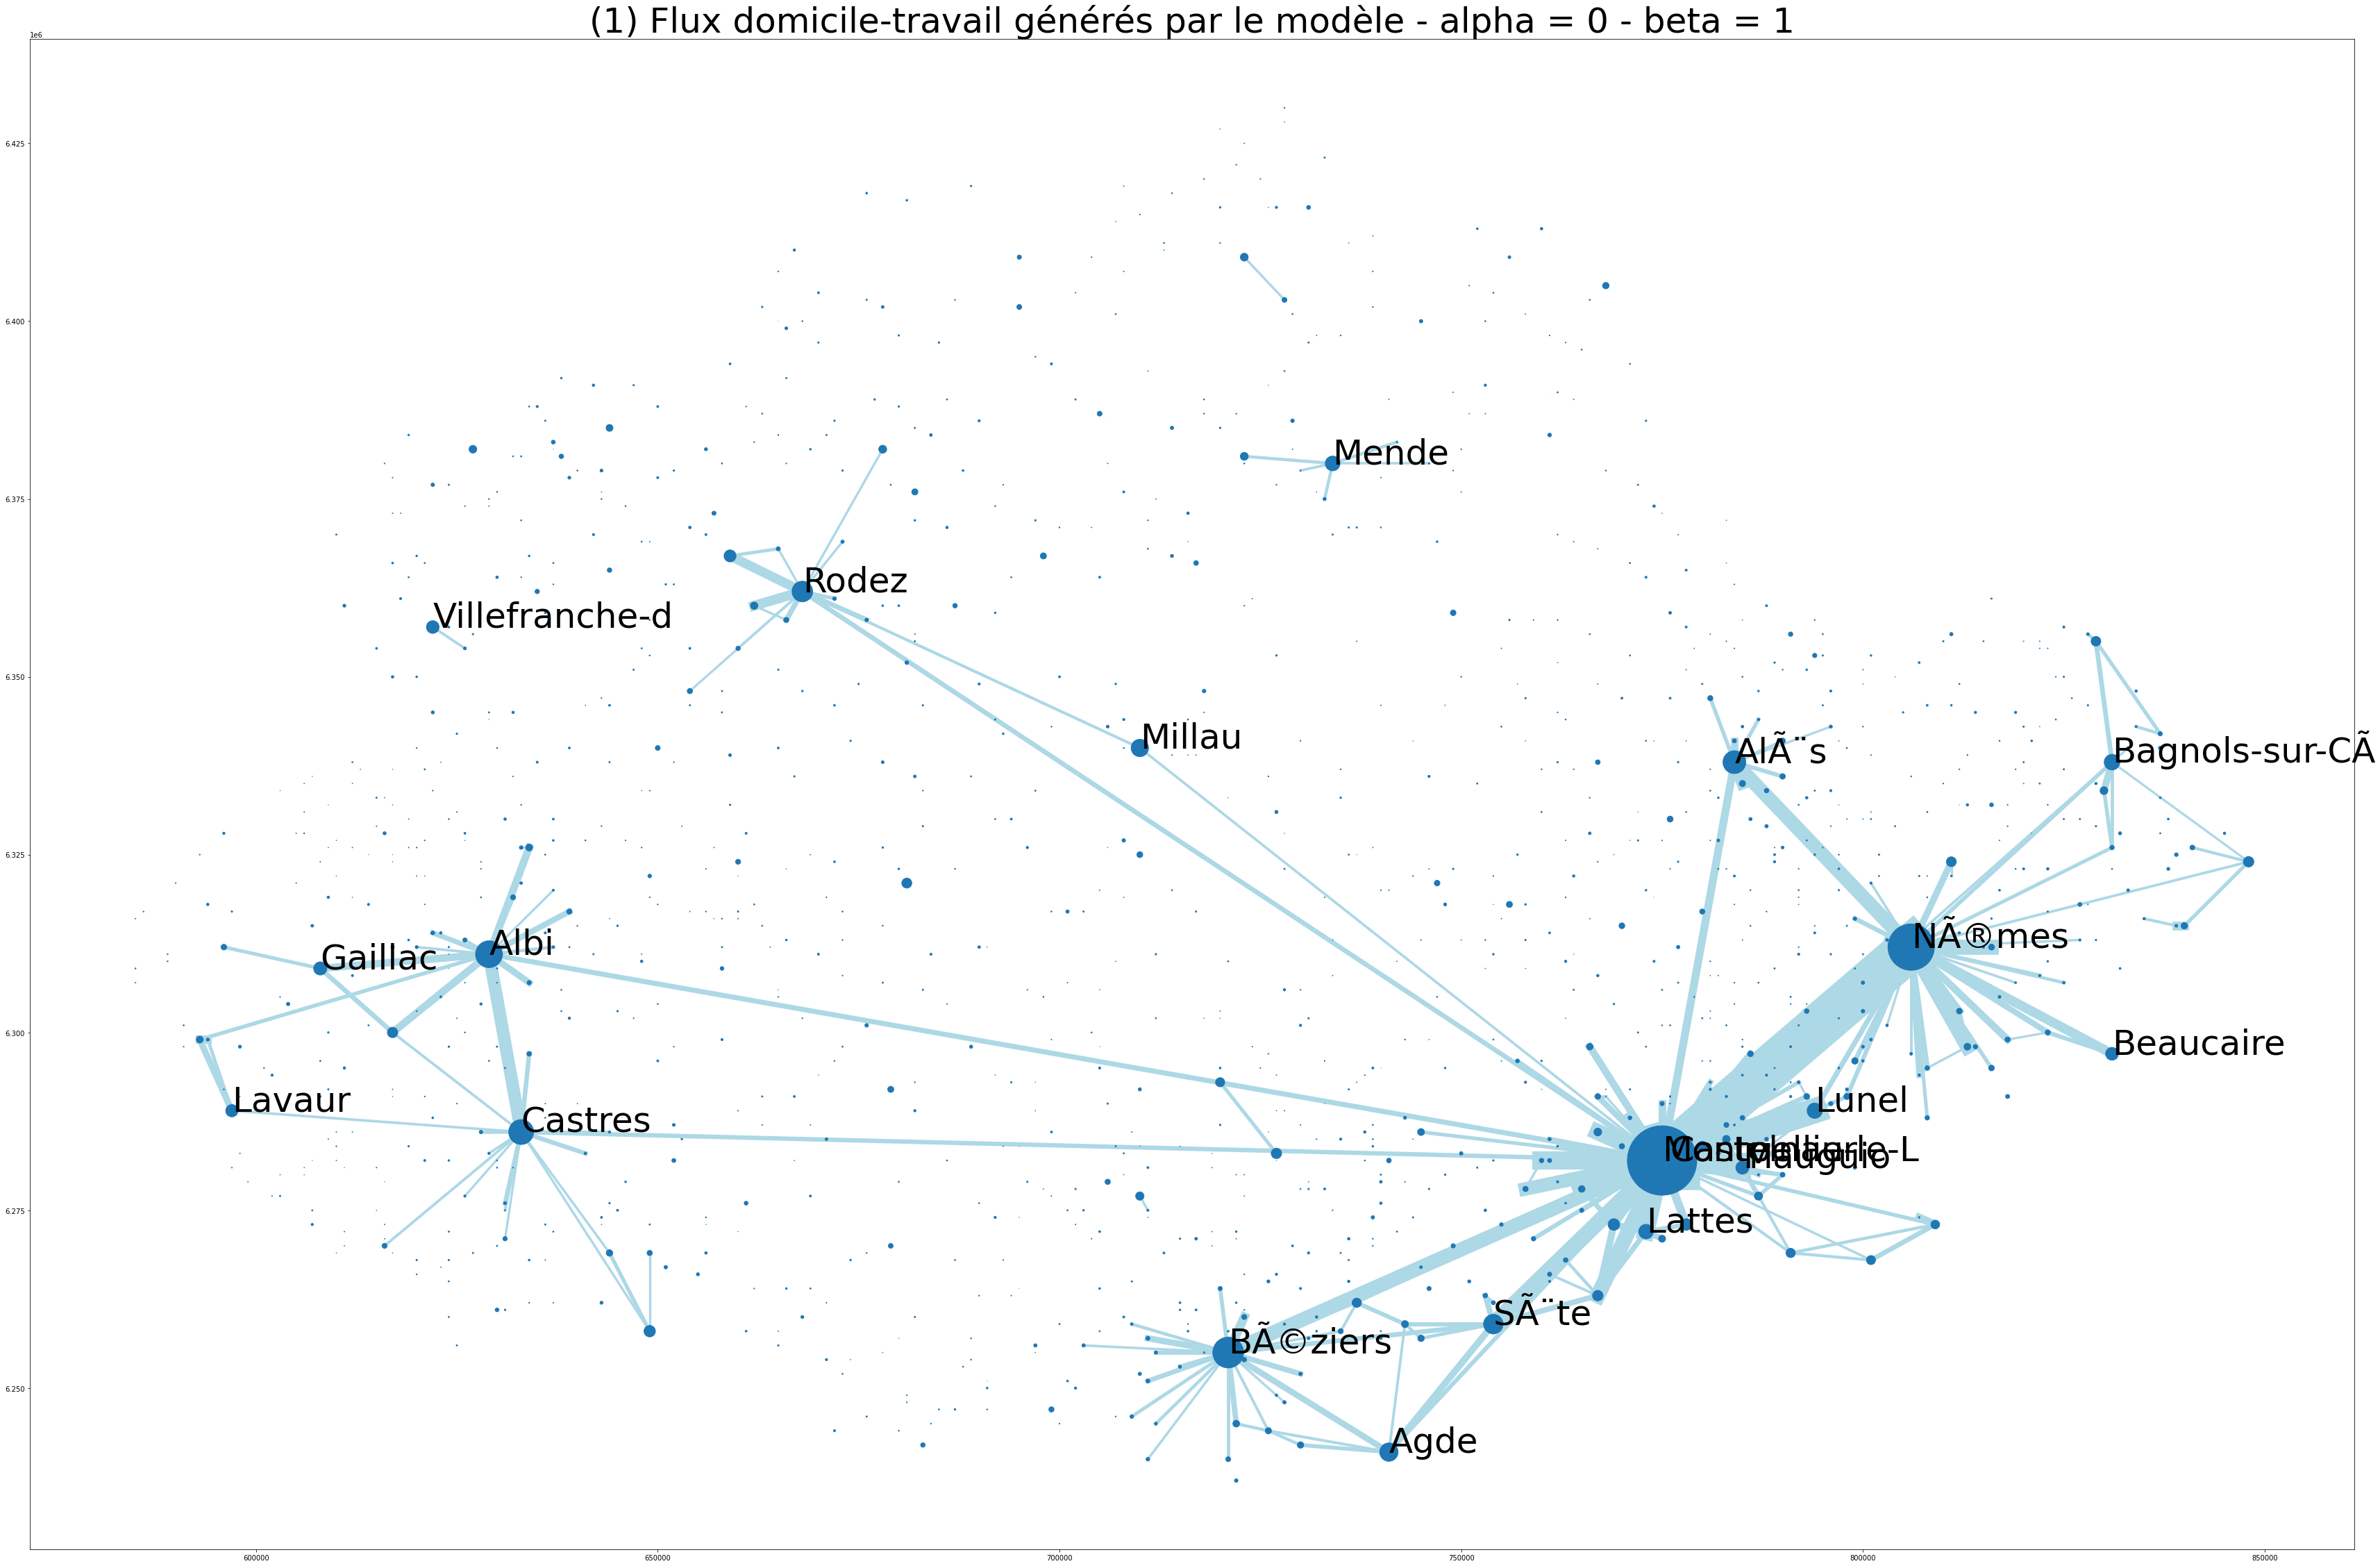

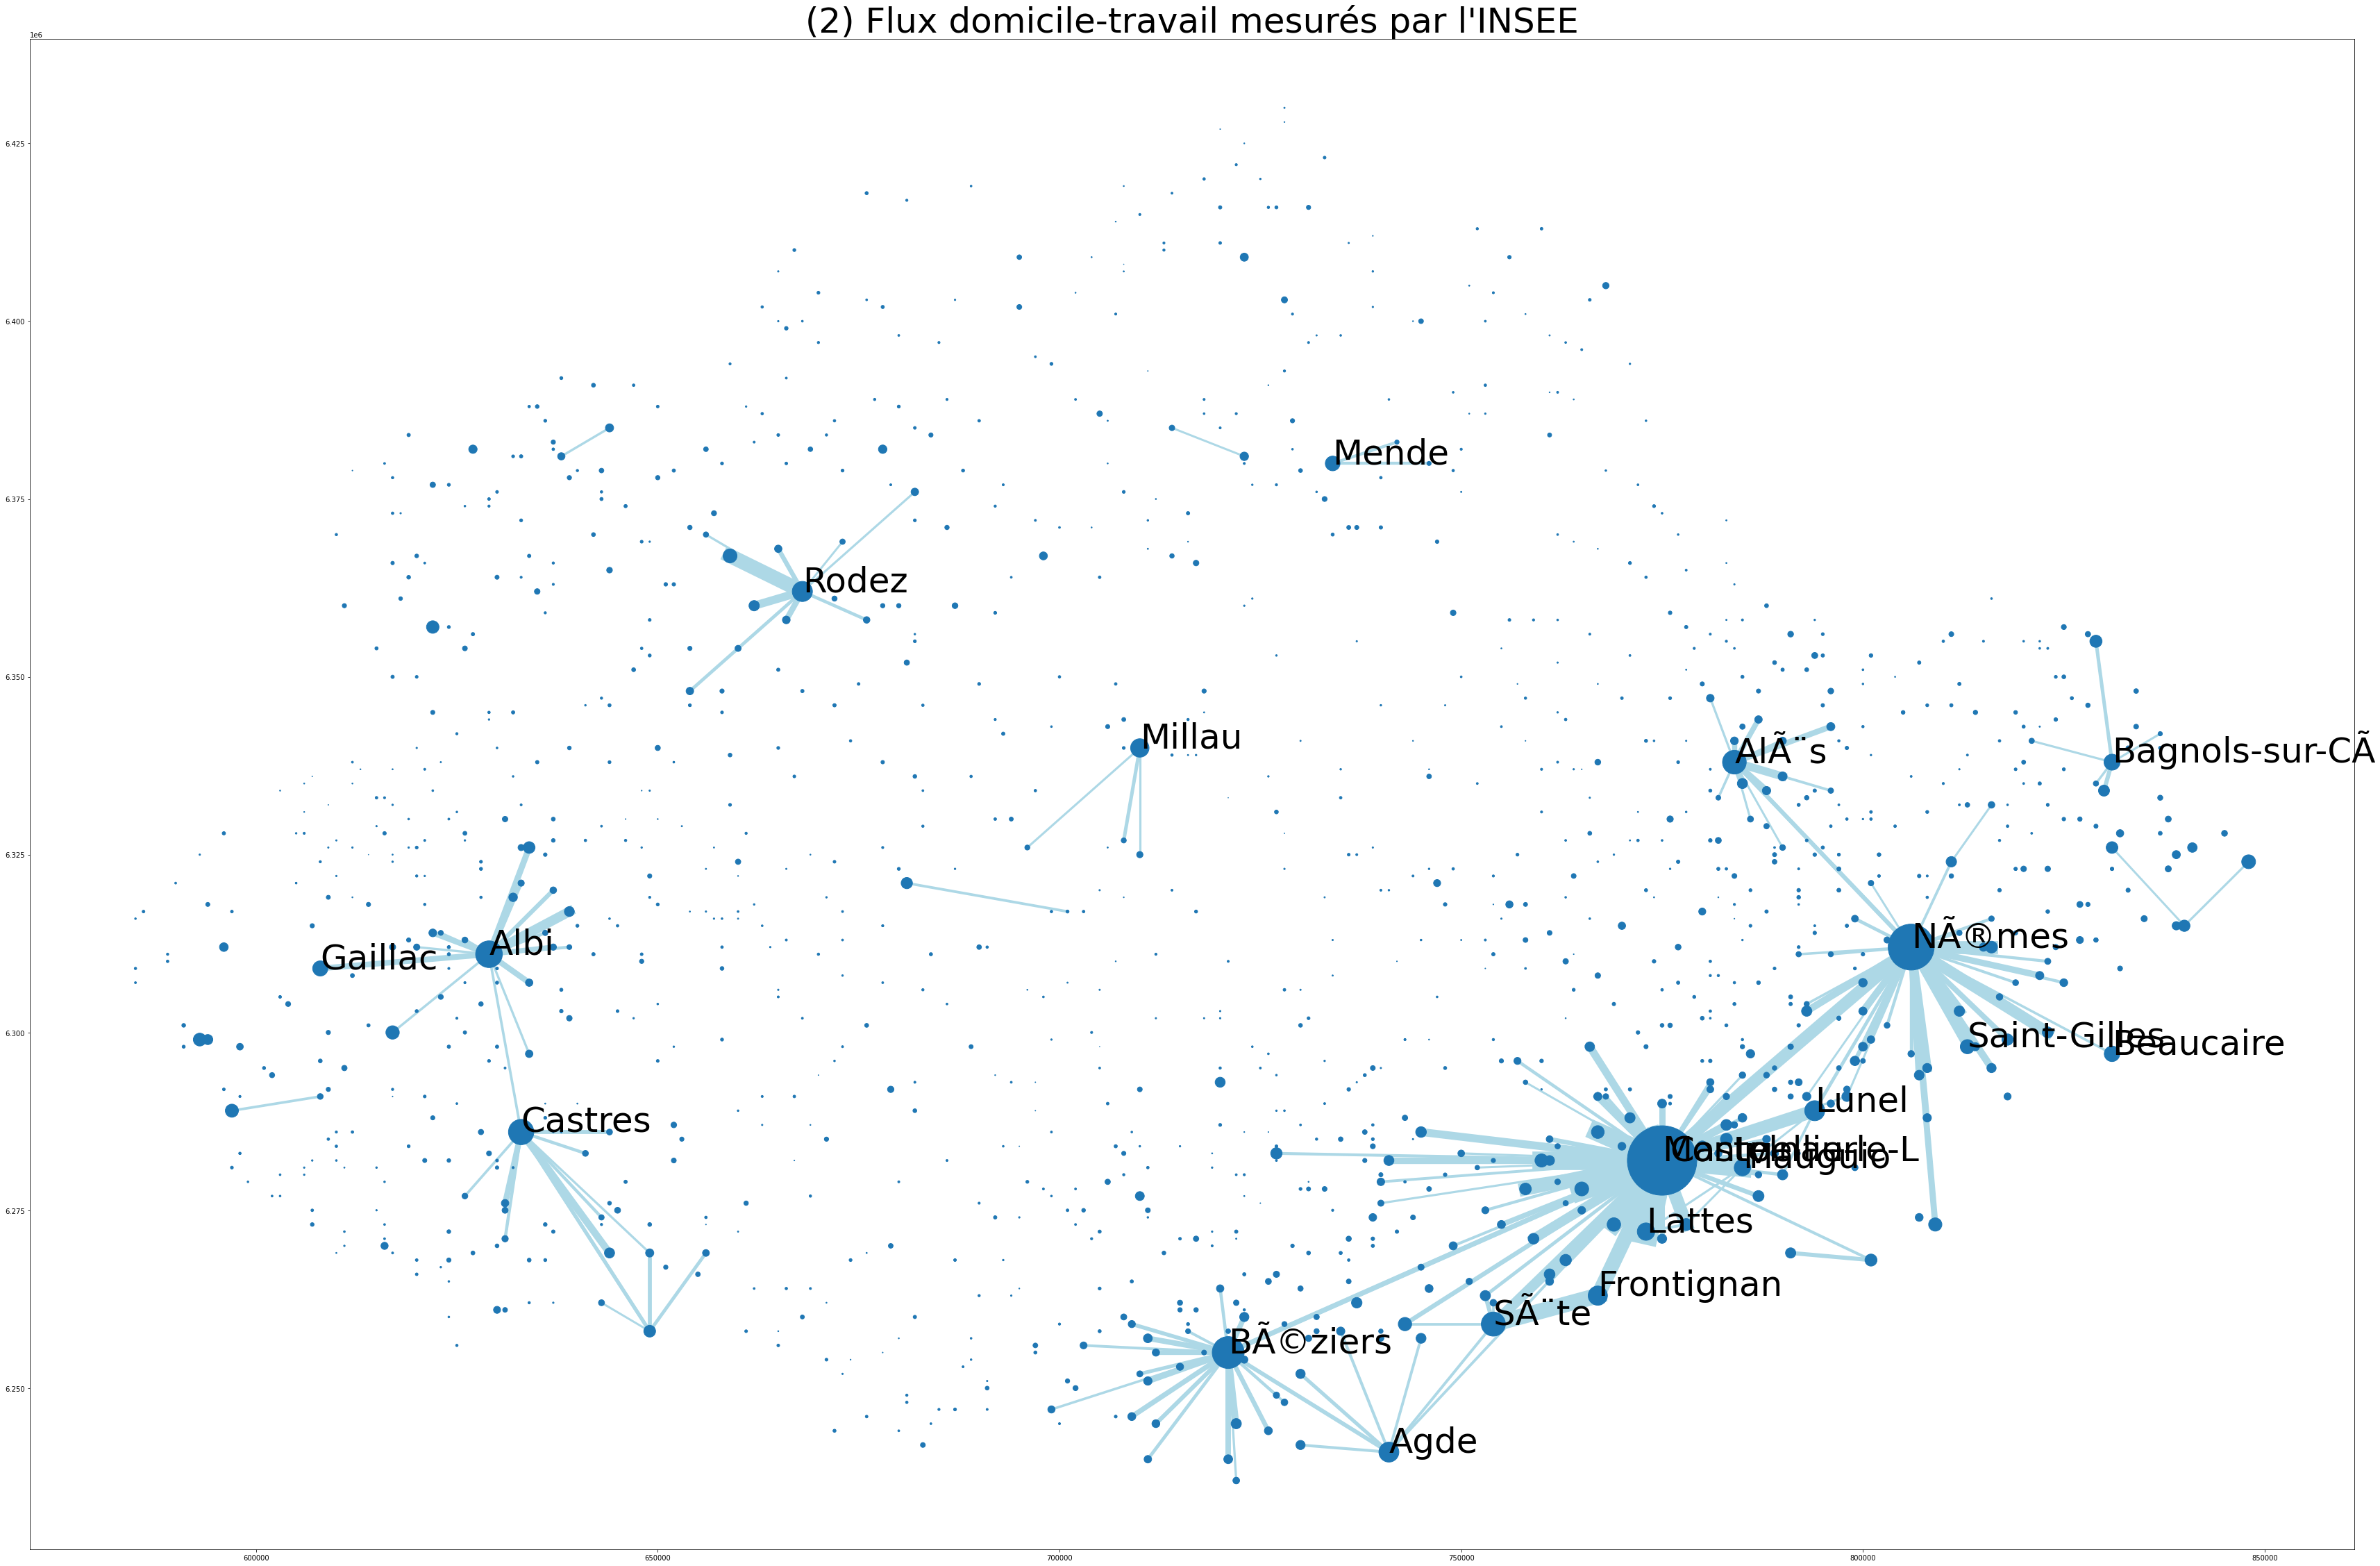

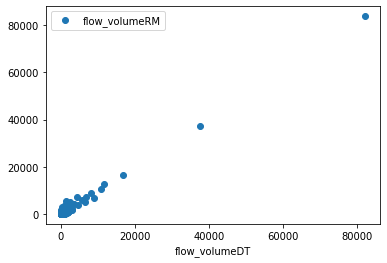

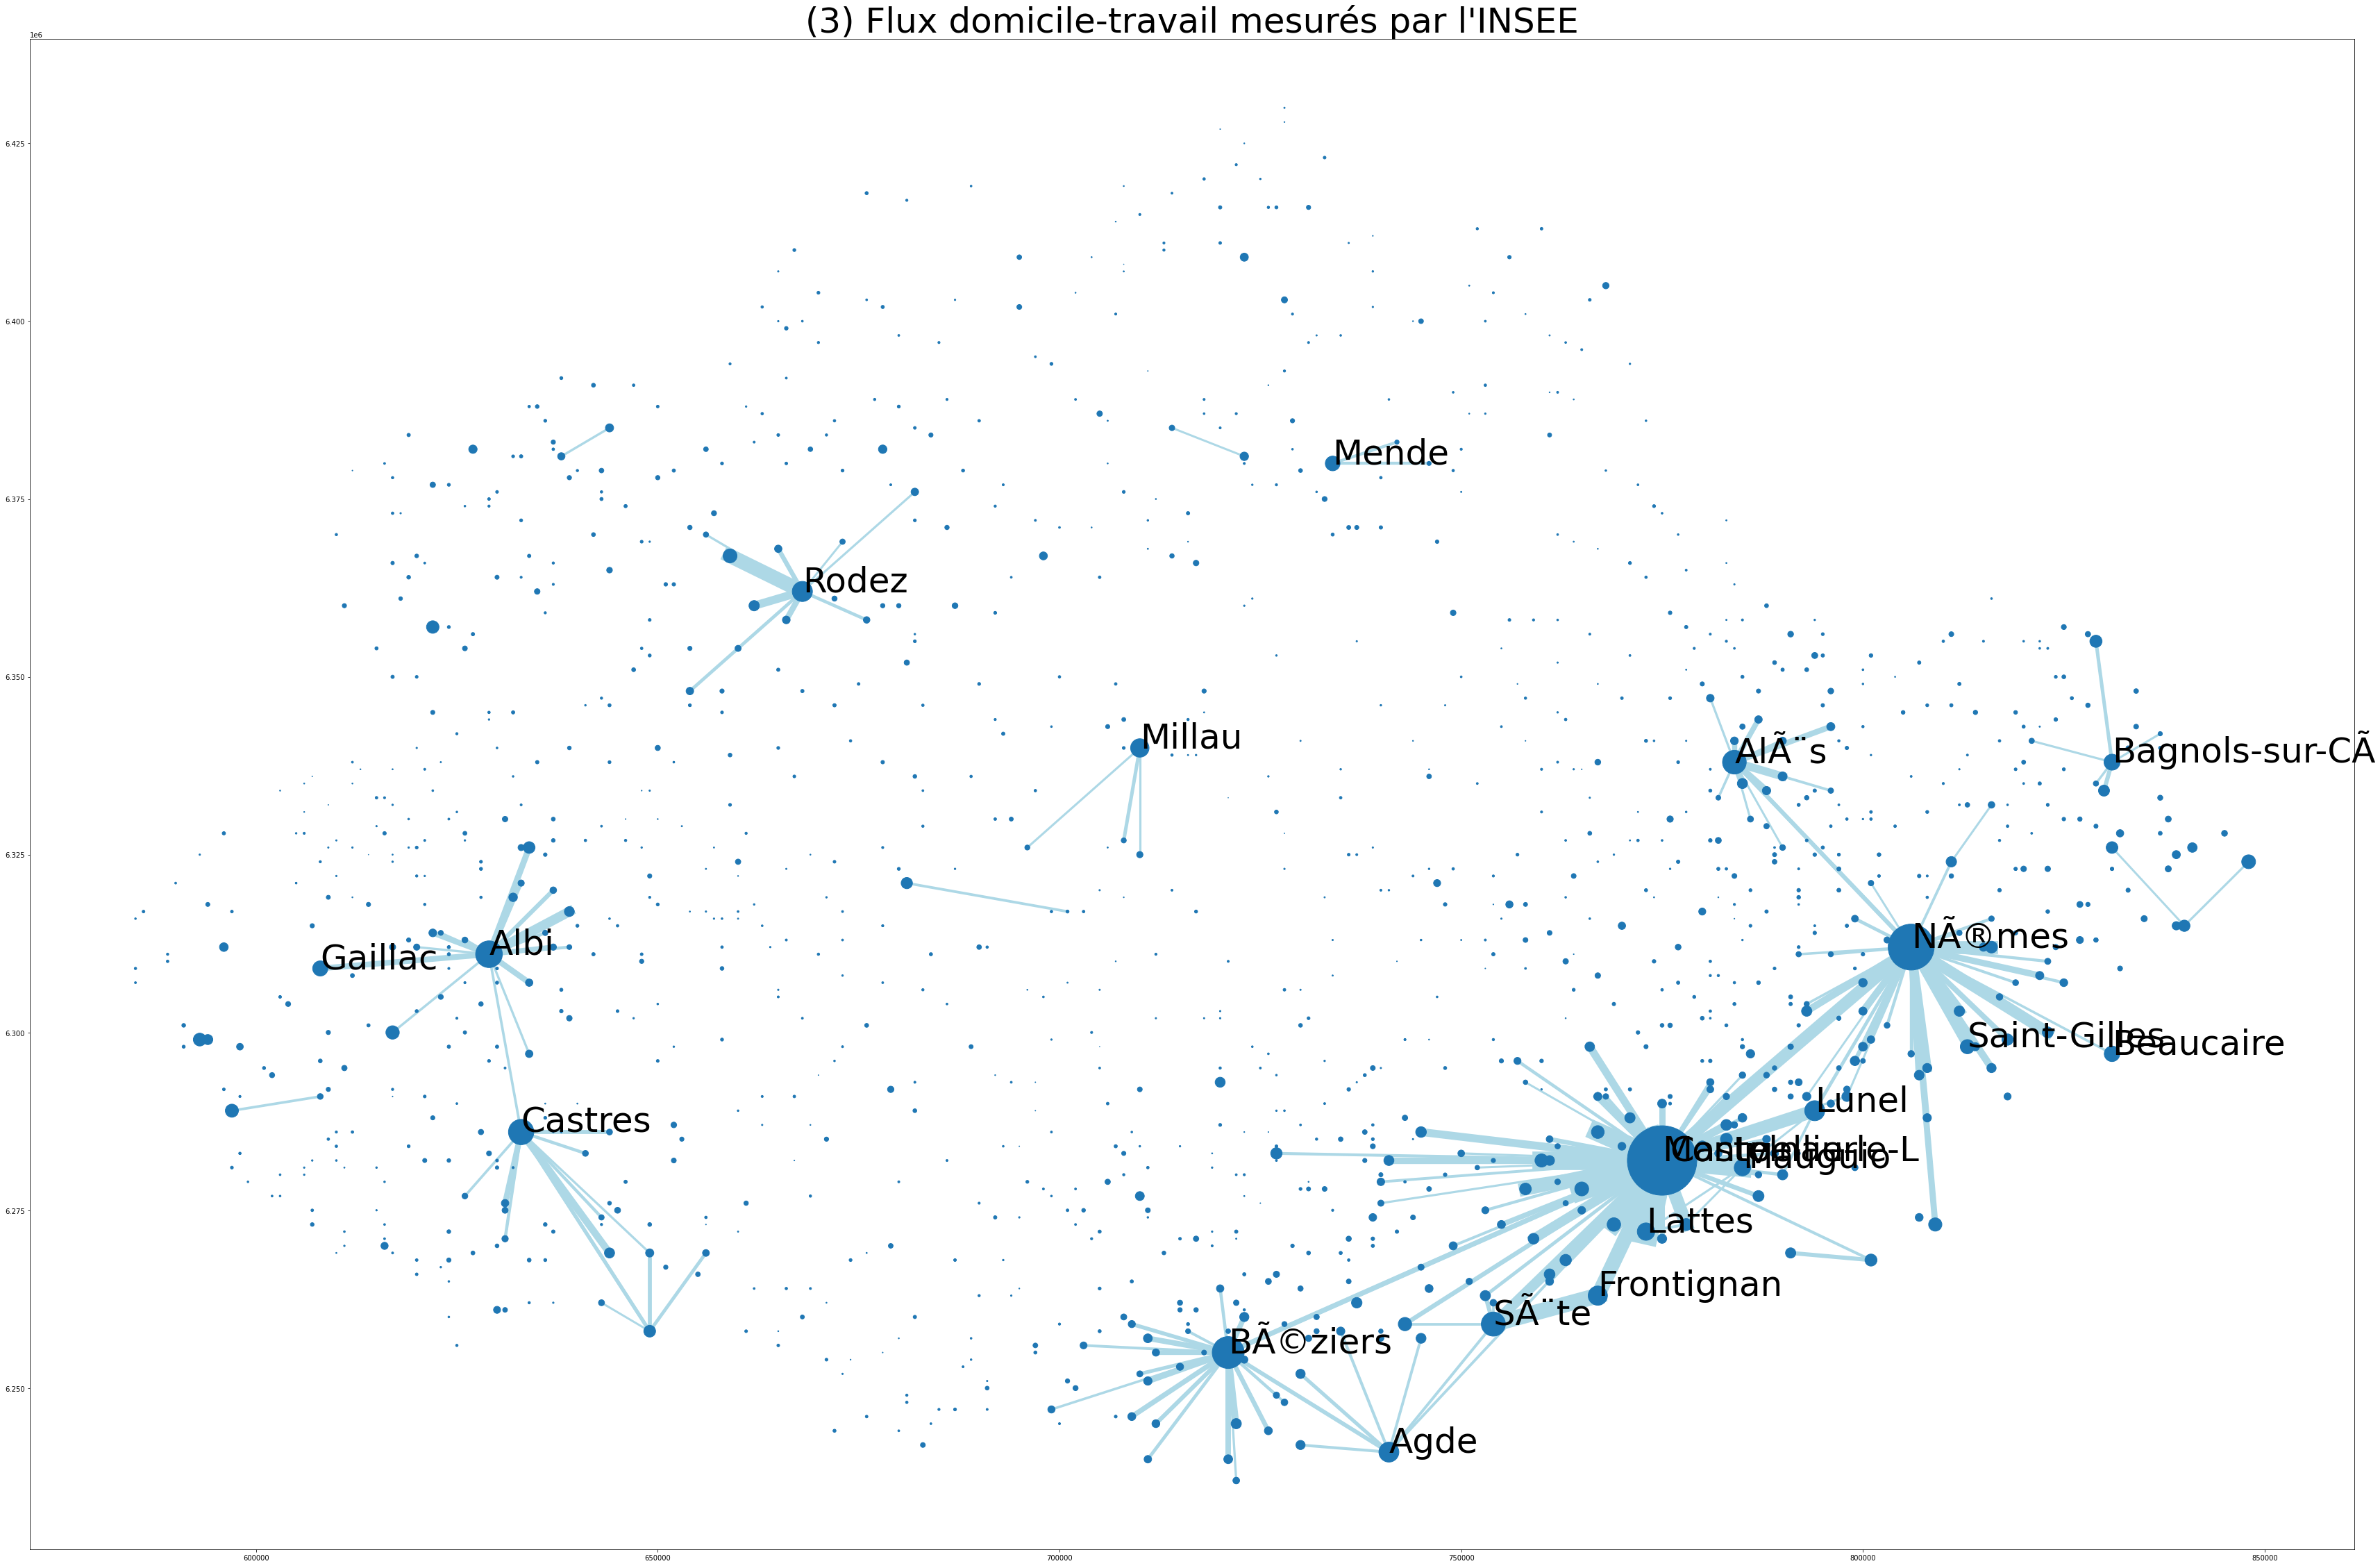

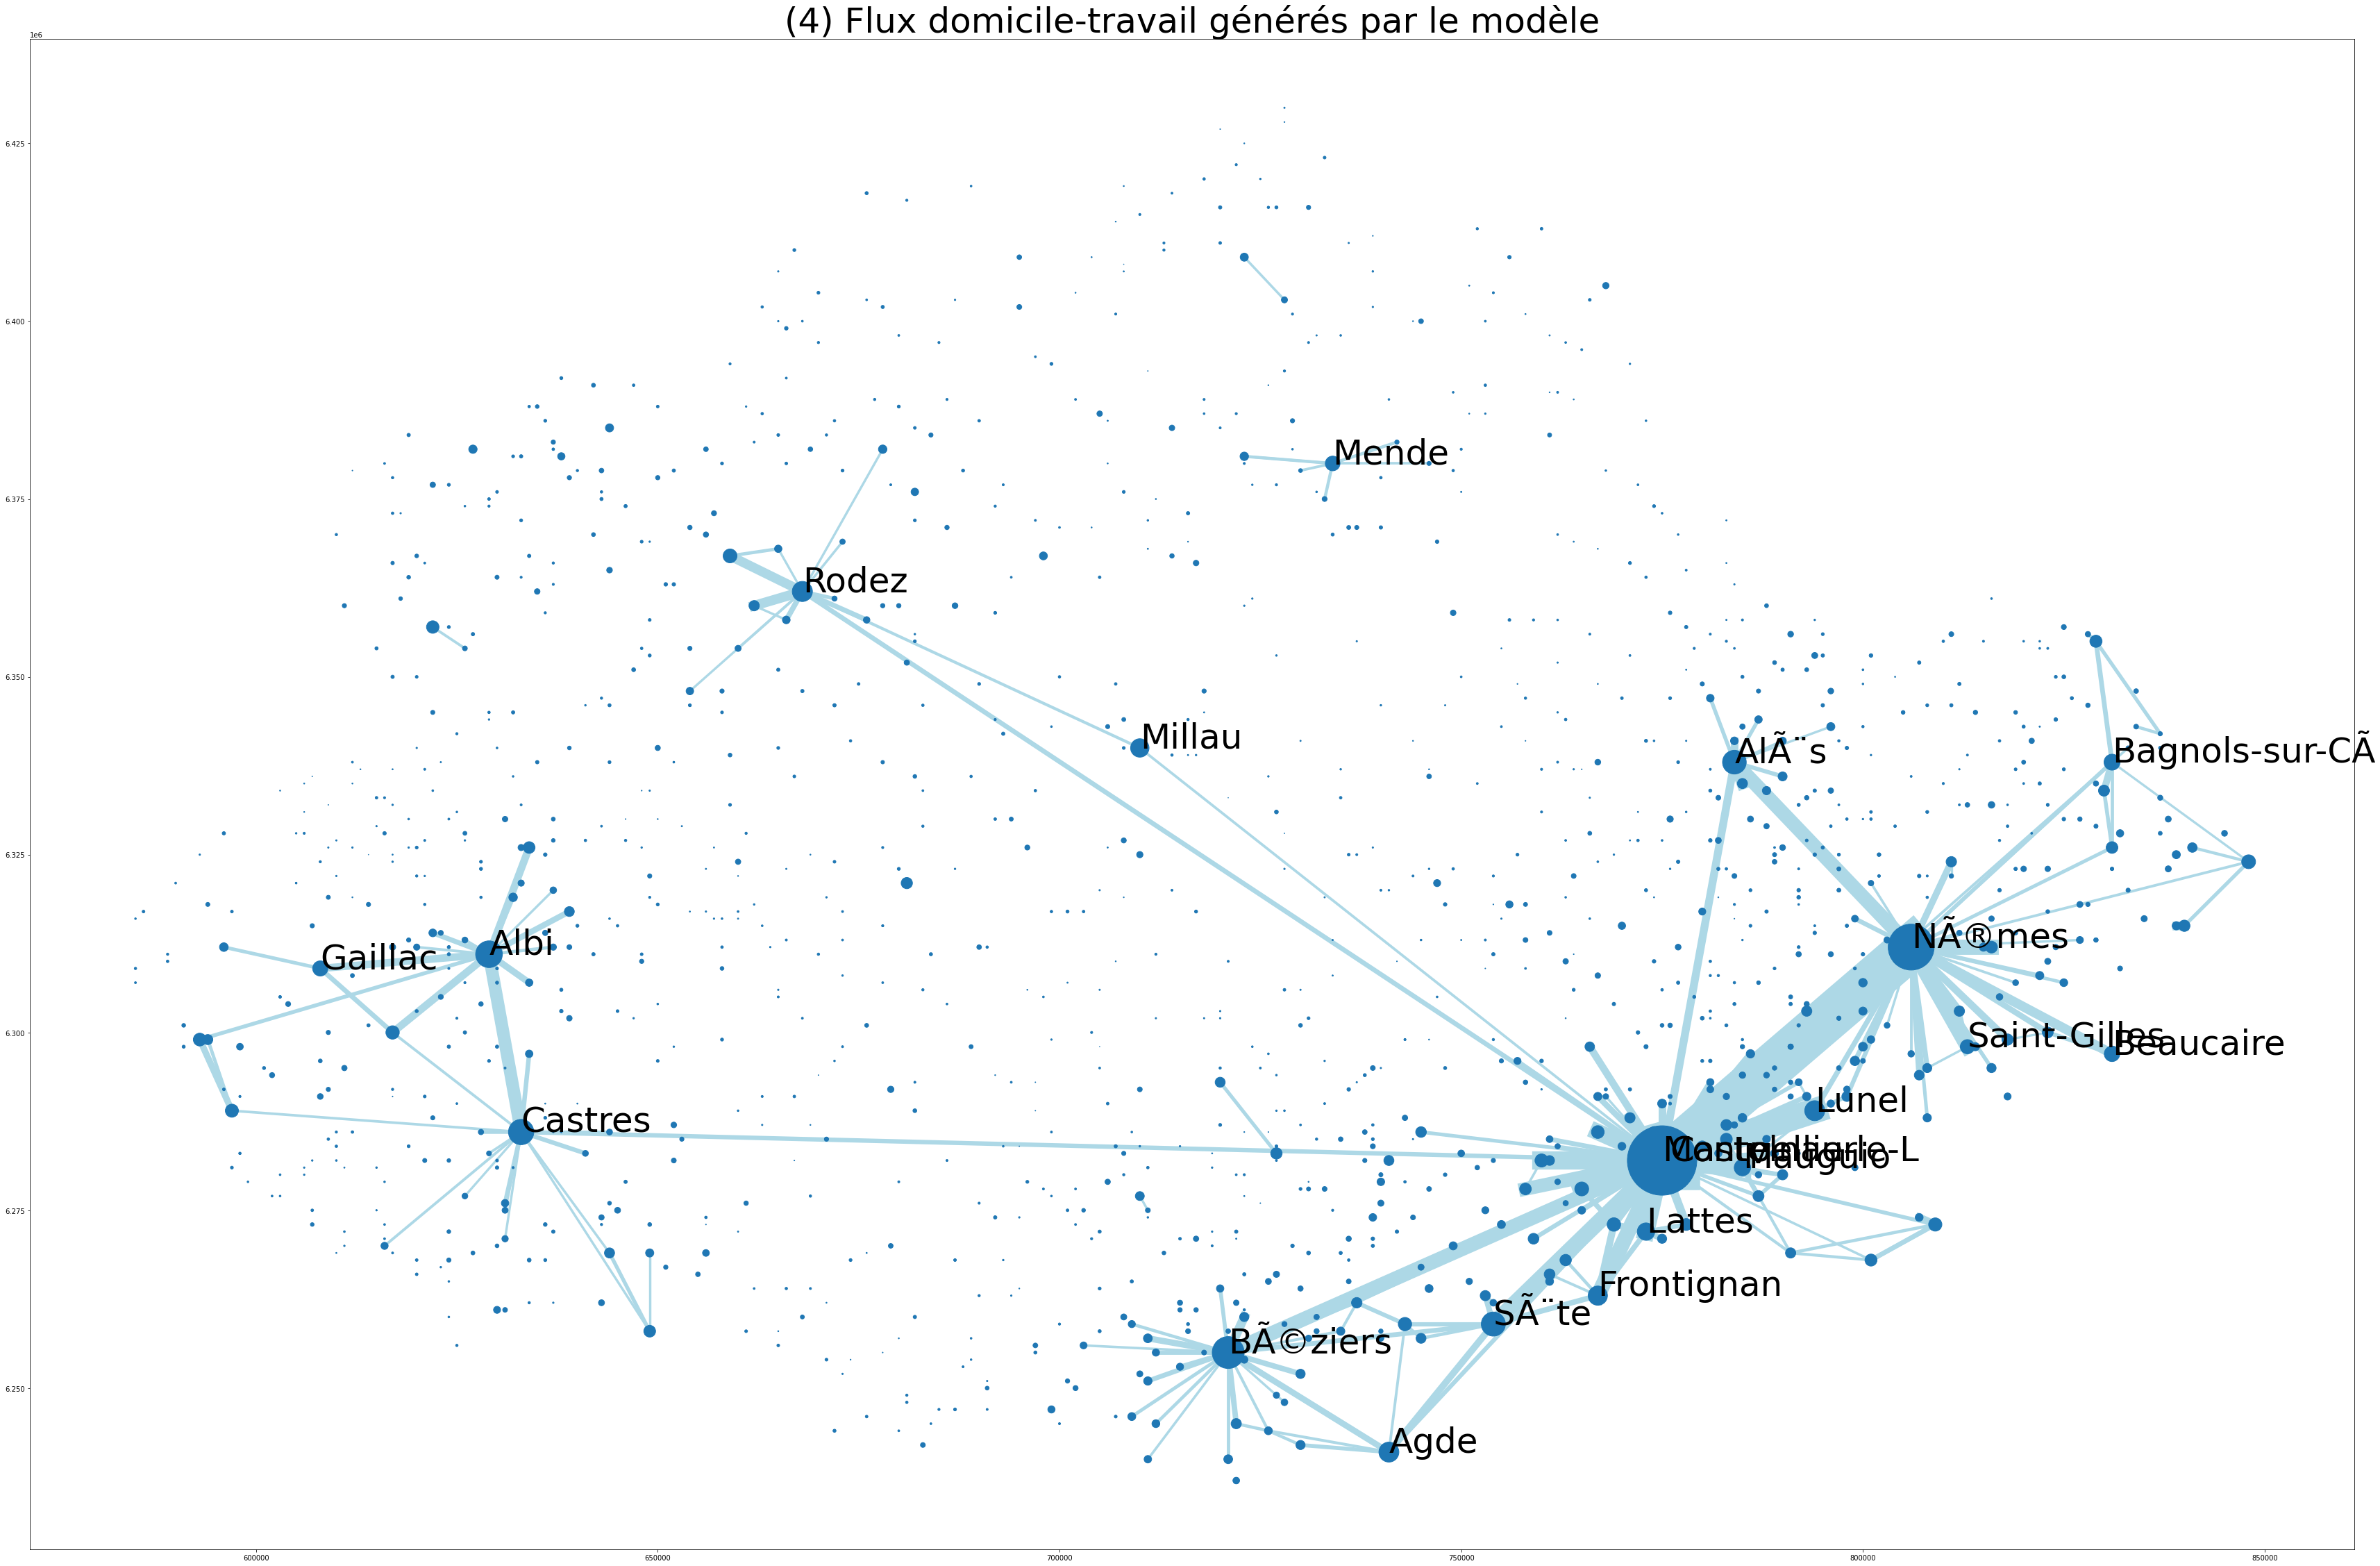

In [14]:
if __name__ == "__main__":
    start_time = time.time()

    # CHOOSE DEPARTMENTS
    lst_departments = ["12", "48", "34", "30", "81"]

    # GET DATA
    (
        sources_territory,
        sinks_territory,
        costs_territory,
        coordonnees,
        raw_flowDT,
    ) = get_data_for_model(lst_departments)
# FIRST RUN
(
    predicted_flux,
    empirical_flux,
    coordonnees,
    plot_sources) = run_model_for_territory(
    sources_territory.copy(),
    sinks_territory,
    costs_territory,
    coordonnees,
    raw_flowDT,
    alpha=0,
    beta=1,
)

# COMPARE INSEE AND MODEL DATA
compare_insee_and_model(predicted_flux, empirical_flux, coordonnees, plot_sources)
compare_thresholds(predicted_flux, empirical_flux)
compute_similarity_index(predicted_flux, empirical_flux, threshold=20)

In [12]:
from pyproj import Proj, transform

import pandas as pd
from pyproj import Proj, transform
cord=pd.read_csv("mobility\data\insee\commune_data\donneesCommunes.csv")
cord['longitude']

0        4.926114
1        5.428017
2        5.372926
3        4.912273
4        5.594320
           ...   
39196         NaN
39197         NaN
39198         NaN
39199         NaN
39200         NaN
Name: longitude, Length: 39201, dtype: float64

In [13]:
from pyproj import Proj, transform
import pandas as pd
from pyproj import Proj, transform
data_folder_path="mobility\data\insee"
coordonnees=pd.read_csv(data_folder_path / "commune_data/donneesCommunes.csv",sep=",",
    usecols=['code_commune_INSEE', 'nom_commune_postal','latitude', 'longitude'],
    dtype={"code_commune_INSEE": str, "nom_commune_postal": str, "latitude": float, "longitude": float},)

TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [5]:

coordonnees = coordonnees.rename(columns={'code_commune_INSEE':'INSEE_COM','nom_commune_postal':'NOM_COM','latitude': 'x', 'longitude': 'y'})
coordonnees=coordonnees.dropna(subset=['NOM_COM','x', 'y'])
coordonnees['NOM_COM'] = coordonnees['NOM_COM'].str.replace(' ', '').str.replace('\'', '')


# define the correct function
def correct(x, y):
    outProj = Proj(init='epsg:2154')
    inProj = Proj(init='epsg:4326')
    lat, long = transform(inProj, outProj, x, y)
    return lat, long

TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [18]:

# apply the correct function to the 'x' and 'y' columns
coordonnees[['x', 'y']] = coordonnees.apply(lambda row: pd.Series(correct(row['x'], row['y'])), axis=1, raw=True)

#coordonnees[['x', 'y']] = coordonnees.apply(lambda row: correct(row['x'], row['y']), axis=1, result_type='expand')

# print the updated DataFrame
coordonnees

array([inf, inf, inf, ..., inf, inf, inf])

In [13]:
df=coordonnees['x','y']
df

KeyError: ('x', 'y')

In [ ]:
def get_data_for_model(
    lst_departments,
    work_home_fluxes_csv=WORK_HOME_FLUXES_CSV,
    communes_coordinates_csv=COMMUNES_COORDINATES_CSV,
    communes_surfaces_csv=COMMUNES_SURFACES_CSV,
    alpha=1,
    beta=1,
):
    """
    Gets data for the given departments.

    Uses the get_insee_data function for active population and jobs
    Uses local data for communes' superficies, intra-communal distance
    and work-home mobility
    (by default, will use the national CSVs in the directory)
    Todo:
     * improve the get_insee_data function for work-home data, coordinates
       and superficies, to not have to deal with local data
     * compute the internal distance within the code instead of using a CSV

    Parameters
    ----------
    lst_departments : list
        List of departements for which to get the data.
    work_home_fluxes_csv : string, optional
        Which CSV to use for work-home data.
        The default is WORK_HOME_FLUXES_CSV defined at the top of the file.
    communes_coordinates_csv : string, optional
        Which CSV to use for coordinates data.
        The default is COMMUNES_COORDINATES_CSV.
    communes_surfaces_csv : string, optional
        Which CSV to use for surfaces data.
        The default is COMMUNES_SURFACES_CSV.
    alpha : float, optional
        The default is 0.
    beta : float, optional
        The default is 1.

    Returns sources_territory, sinks_territory, costs_territory,
            coordonnees, raw_flowDT
            (all of them are pandas dataframes)

    """
    # ===================
    # IMPORT AND PROCESS THE DATA

    # Import the data (active population and jobs)
    insee_data = get_insee_data()
    db_actifs = insee_data["active_population"]
    db_emplois = insee_data["jobs"]

    db_emplois["EMPLT"] = db_emplois[
        [
            "n_jobs_CS1",
            "n_jobs_CS2",
            "n_jobs_CS3",
            "n_jobs_CS4",
            "n_jobs_CS5",
            "n_jobs_CS6",
        ]
    ].sum(axis=1)
    db_emplois.reset_index(inplace=True)

    db_actifs["ACT"] = db_actifs[
        [
            "active_pop_CS1",
            "active_pop_CS2",
            "active_pop_CS3",
            "active_pop_CS4",
            "active_pop_CS5",
            "active_pop_CS6",
        ]
    ].sum(axis=1)
    db_actifs.reset_index(inplace=True)

    # Only keep the sinks in the chosen departements
    sinks_territory = db_emplois.loc[:, ["CODGEO", "EMPLT"]]
    sinks_territory["DEP"] = sinks_territory["CODGEO"].str.slice(0, 2)
    mask = sinks_territory["DEP"].apply(lambda x: x in lst_departments)
    sinks_territory = sinks_territory.loc[mask]

    sinks_territory = sinks_territory.set_index("CODGEO")
    sinks_territory.rename(columns={"EMPLT": "sink_volume"}, inplace=True)
    sinks_territory = sinks_territory.drop(columns=["DEP"])

    # Only keep the sinks in the chosen departements
    sources_territory = db_actifs.loc[:, ["CODGEO", "ACT"]]
    sources_territory["DEP"] = sources_territory["CODGEO"].str.slice(0, 2)
    mask = sources_territory["DEP"].apply(lambda x: x in lst_departments)
    sources_territory = sources_territory.loc[mask]

    sources_territory = sources_territory.set_index("CODGEO")
    sources_territory = sources_territory.drop(columns=["DEP"])
    sources_territory.rename(columns={"ACT": "source_volume"}, inplace=True)

    data_folder_path = Path(os.path.dirname("examples/Millau/"))

    # Import the INSEE data on the work-home mobility on Millau
    file_path = os.path.join(data_folder_path, work_home_fluxes_csv)
    raw_flowDT = pd.read_csv(
        file_path,
        sep=";",
        usecols=["COMMUNE", "DCLT", "IPONDI", "TRANS"],
        dtype={"COMMUNE": str, "DCLT": str, "IPONDI": float, "TRANS": int},
    )

    # Only keep the flows in the given departments

    raw_flowDT["DEP"] = raw_flowDT["COMMUNE"].str.slice(0, 2)
    raw_flowDT["DEP2"] = raw_flowDT["DCLT"].str.slice(0, 2)
    mask = raw_flowDT["DEP"].apply(lambda x: x in lst_departments)
    mask2 = raw_flowDT["DEP2"].apply(lambda x: x in lst_departments)
    raw_flowDT = raw_flowDT.loc[mask]
    raw_flowDT = raw_flowDT.loc[mask2]

    # Import the geographic data on the work-home mobility on Millau

    coordonnees = pd.read_csv(
        data_folder_path / communes_coordinates_csv,
        sep=",",
        usecols=["NOM_COM", "INSEE_COM", "x", "y"],
        dtype={"INSEE_COM": str},
    )
    coordonnees.set_index("INSEE_COM", inplace=True)
    coordonnees["x"] = coordonnees["x"] * 1000
    coordonnees["y"] = coordonnees["y"] * 1000

    surfaces = pd.read_csv(
        data_folder_path / communes_surfaces_csv,
        sep=",",
        usecols=["INSEE_COM", "distance_interne"],
        dtype={"INSEE_COM": str},
    )
    surfaces.set_index("INSEE_COM", inplace=True)

    # Compute the distance between cities
    #    distance between i and j = (x_i - x_j)**2 + (y_i - y_j)**2
    lst_communes = sources_territory.index.to_numpy()
    idx_from_to = np.array(np.meshgrid(lst_communes, lst_communes)).T.reshape(-1, 2)
    idx_from = idx_from_to[:, 0]
    idx_to = idx_from_to[:, 1]
    costs_territory = pd.DataFrame(
        {"from": idx_from, "to": idx_to, "cost": np.zeros(idx_to.shape[0])}
    )
    costs_territory = pd.merge(
        costs_territory, coordonnees, left_on="from", right_index=True
    )
    costs_territory.rename(columns={"x": "from_x", "y": "from_y"}, inplace=True)
    costs_territory = pd.merge(
        costs_territory, coordonnees, left_on="to", right_index=True
    )
    costs_territory.rename(columns={"x": "to_x", "y": "to_y"}, inplace=True)

    costs_territory = pd.merge(
        costs_territory, surfaces, left_on="from", right_index=True
    )

    costs_territory["cost"] = np.sqrt(
        (costs_territory["from_x"] / 1000 - costs_territory["to_x"] / 1000) ** 2
        + (costs_territory["from_y"] / 1000 - costs_territory["to_y"] / 1000) ** 2
    )

    # distance if the origin and the destination is the same city
    # is internal distance = 128*r / 45*pi
    # where r = sqrt(surface of the city)/pi
    mask = costs_territory["from"] != costs_territory["to"]
    costs_territory["cost"].where(
        mask, other=costs_territory["distance_interne"], inplace=True
    )

    return (
        sources_territory,
        sinks_territory,
        costs_territory,
        coordonnees,
        raw_flowDT,
    )

In [4]:
import numpy as np
r=np.sqrt(3.687)/np.pi

In [5]:
d=128*r / 45*np.pi

In [6]:
d

5.461777759694758

In [ ]:
from mobility.parsers.permanent_db_facilities import prepare_facilities
# Télécharger les données et préparer les fichiers pour les équipements
prepare_facilities()
# Utiliser les données pour des analyses
import pandas as pd
malls = pd.read_parquet('data/insee/facilities/malls.parquet')
shops = pd.read_parquet('data/insee/facilities/shops.parquet')
schools = pd.read_parquet('data/insee/facilities/schools.parquet')

import pandas as pd
from mobility.insee_data import get_insee_data

insee_data = get_insee_data()

# Get the repartition of jobs in the city with geographic code 12345
jobs = insee_data["jobs"]
jobs_for_city_12345 = jobs.loc["12345"]

# Get the repartition of schools in the city with geographic code 67890
schools = insee_data["schools"]
schools_for_city_67890 = schools.loc["67890"]